Group Number - WS25-PR9

Project title - American Sign Language(ASL) alphabet hand gestures

Group members - Ashwin Shahaji Walunj

Importing Libraries

In [2]:
import os

import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from mediapipe.tasks import python as mp_tasks
from mediapipe.tasks.python import vision
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
base_path = 'dataset/'

training_path = base_path + 'train'

validation_path = base_path + 'val'

meta_training_path = base_path + 'meta_train'

predict_path = base_path + 'test'


Dataset Loading and Preprocessing

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False
)

train_generator = train_datagen.flow_from_directory(
    directory=training_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

val_datagen = ImageDataGenerator(
    rescale=1. / 255
)

val_generator = train_datagen.flow_from_directory(
    directory=validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

meta_train_datagen = ImageDataGenerator(
    rescale=1. / 255
)

meta_train_generator = meta_train_datagen.flow_from_directory(
    directory=meta_training_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=predict_path,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode='sparse',
    shuffle=False
)

class_indices = train_generator.class_indices

label_map = {name: idx for name, idx in class_indices.items()}


Found 33138 images belonging to 28 classes.
Found 8275 images belonging to 28 classes.
Found 14210 images belonging to 28 classes.
Found 14174 images belonging to 28 classes.


In [5]:
num_classes = len(class_indices)

Model C - Geometric Classifier

In [ ]:
MODEL_PATH = "hand_landmarker.task"

BaseOptions = mp_tasks.BaseOptions
HandLandmarkerOptions = vision.HandLandmarkerOptions
HandLandmarker = vision.HandLandmarker
VisionRunningMode = vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=MODEL_PATH),
    running_mode=VisionRunningMode.IMAGE,
    num_hands=1,
    min_hand_detection_confidence=0.1,
    min_tracking_confidence=0.1,
    min_hand_presence_confidence=0.1
)
landmarker = HandLandmarker.create_from_options(options)


def extract_hand_features_xyz_wrist_norm(image_rgb):
    if image_rgb.dtype != np.uint8:
        image_rgb = (image_rgb * 255).astype(np.uint8)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

    result = landmarker.detect(mp_image)
    if not result.hand_landmarks:
        return None

    lm_list = result.hand_landmarks[0]

    pts = np.array([[lm.x, lm.y, lm.z] for lm in lm_list], dtype="float32")
    wrist = pts[0:1, :]
    pts_rel = pts[1:] - wrist
    dists = np.linalg.norm(pts_rel, axis=1)
    scale = dists.max() + 1e-6
    pts_norm = pts_rel / scale
    return pts_norm.flatten()

In [ ]:
X_geo_train = []
y_geo_train = []

for step in range(len(train_generator)):
    rgb_batch, y_batch = next(train_generator)
    for i in range(rgb_batch.shape[0]):
        img = rgb_batch[i]  # (H, W, 3), already normalized 0–1
        label = int(y_batch[i])
        feat = extract_hand_features_xyz_wrist_norm(img)
        if feat is not None:
            X_geo_train.append(feat)
            y_geo_train.append(label)

X_geo_train = np.array(X_geo_train, dtype="float32")
y_geo_train = np.array(y_geo_train, dtype="int32")


In [8]:
X_geo_meta_train = []
y_geo_meta_train = []

for step in range(len(meta_train_generator)):
    rgb_batch, y_batch = next(meta_train_generator)
    for i in range(rgb_batch.shape[0]):
        img = rgb_batch[i]  # (H, W, 3), already normalized 0–1
        label = int(y_batch[i])
        feat = extract_hand_features_xyz_wrist_norm(img)
        if feat is not None:
            X_geo_meta_train.append(feat)
            y_geo_meta_train.append(label)

X_geo_meta_train = np.array(X_geo_meta_train, dtype="float32")
y_geo_meta_train = np.array(y_geo_meta_train, dtype="int32")

In [9]:
X_geo_val = []
y_geo_val = []

for step in range(len(val_generator)):
    rgb_batch, y_batch = next(val_generator)
    for i in range(rgb_batch.shape[0]):
        img = rgb_batch[i]
        label = int(y_batch[i])

        feat = extract_hand_features_xyz_wrist_norm(img)
        if feat is not None:
            X_geo_val.append(feat)
            y_geo_val.append(label)

X_geo_val = np.array(X_geo_val, dtype="float32")
y_geo_val = np.array(y_geo_val, dtype="int32")

X_geo_test = []
y_geo_test = []

for step in range(len(test_generator)):
    rgb_batch, y_batch = next(test_generator)
    for i in range(rgb_batch.shape[0]):
        img = rgb_batch[i]
        label = int(y_batch[i])

        feat = extract_hand_features_xyz_wrist_norm(img)
        if feat is not None:
            X_geo_test.append(feat)
            y_geo_test.append(label)

X_geo_test = np.array(X_geo_test, dtype="float32")
y_geo_test = np.array(y_geo_test, dtype="int32")


In [10]:
input_dim = X_geo_train.shape[1]

inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_c = Model(inputs=inputs, outputs=outputs)

model_c.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_c = model_c.fit(
    X_geo_train, y_geo_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_geo_val, y_geo_val),
    shuffle=True,
    verbose=1,
    callbacks=[early_stop]
)

2026-01-04 11:45:39.794929: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-04 11:45:39.795113: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-04 11:45:39.795116: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-04 11:45:39.795676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-04 11:45:39.795875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2026-01-04 11:45:40.260928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


510/510 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4579 - loss: 1.8168 - val_accuracy: 0.9107 - val_loss: 0.5318
Epoch 2/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8418 - loss: 0.6357 - val_accuracy: 0.9305 - val_loss: 0.4332
Epoch 3/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8796 - loss: 0.5349 - val_accuracy: 0.9310 - val_loss: 0.4105
Epoch 4/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8942 - loss: 0.5026 - val_accuracy: 0.9368 - val_loss: 0.4002
Epoch 5/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8967 - loss: 0.5135 - val_accuracy: 0.9319 - val_loss: 0.3966
Epoch 6/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9039 - loss: 0.4886 - val_accuracy: 0.9430 - val_loss: 0.3687
Epoch 7/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9077 - loss: 0.4783 - val_accuracy: 0.9348 - val_loss: 0.3856
Epoch 8/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9072 - loss: 0.4833 - val_accuracy: 0.9371 - val_

Model B - Custom CNN

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, Input, \
    GlobalAveragePooling2D

model_b = tf.keras.models.Sequential()

model_b.add(Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))

model_b.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_b.add(BatchNormalization())
model_b.add(MaxPool2D(pool_size=2))

model_b.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_b.add(BatchNormalization())
model_b.add(MaxPool2D(pool_size=2))

model_b.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_b.add(BatchNormalization())
model_b.add(MaxPool2D(pool_size=2))
model_b.add(Dropout(0.3))

model_b.add(GlobalAveragePooling2D())
model_b.add(Dense(512, activation='relu'))
model_b.add(Dropout(0.5))

model_b.add(Dense(num_classes, activation='softmax', dtype="float32"))

model_b.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

history_b = model_b.fit(train_generator,
                        epochs=19,
                        validation_data=val_generator,
                        callbacks=[early_stop, lr_reducer],
                        verbose=1)

/Users/ashwinwalunj/asl-recognisation/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/19
518/518 ━━━━━━━━━━━━━━━━━━━━ 244s 468ms/step - accuracy: 0.0673 - loss: 3.2712 - val_accuracy: 0.0976 - val_loss: 3.1455 - learning_rate: 5.0000e-05
Epoch 2/19
518/518 ━━━━━━━━━━━━━━━━━━━━ 262s 505ms/step - accuracy: 0.1374 - loss: 2.9254 - val_accuracy: 0.2680 - val_loss: 2.5912 - learning_rate: 5.0000e-05
Epoch 3/19
518/518 ━━━━━━━━━━━━━━━━━━━━ 231s 445ms/step - accuracy: 0.2155 - loss: 2.6188 - val_accuracy: 0.3589 - val_loss: 2.2743 - learning_rate: 5.0000e-05
Epoch 4/19
518/518 ━━━━━━━━━━━━━━━━━━━━ 230s 444ms/step - accuracy: 0.2966 - loss: 2.3073 - val_accuracy: 0.4421 - val_loss: 2.0090 - learning_rate: 5.0000e-05
Epoch 5/19
518/518 ━━━━━━━━━━━━━━━━━━━━ 234s 451ms/step - accuracy: 0.3706 - loss: 2.0347 - val_accuracy: 0.5258 - val_loss: 1.7282 - learning_rate: 5.0000e-05
Epoch 6/19
518/518 ━━━━━━━━━━━━━━━━━━━━ 245s 472ms/step - accuracy: 0.4433 - loss: 1.7875 - val_accuracy: 0.5262 - val_loss: 1.6062 - learning_rate: 5.0000e-05
Epoch 7/19
518/518 ━━━━━━━━━━━━━━━━━━━━ 

Model E - EfficientNetB0

In [12]:
base_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    horizontal_flip=False
)

train_gen_eff = base_datagen.flow_from_directory(
    directory=training_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
)

base_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_gen_eff = base_val_datagen.flow_from_directory(
    directory=validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
)

meta_eff_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

meta_train_gen_eff = meta_train_datagen.flow_from_directory(
    directory=meta_training_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

base_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, )

test_gen_eff = base_test_datagen.flow_from_directory(
    directory=predict_path,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode='sparse',
    shuffle=False
)


Found 33138 images belonging to 28 classes.
Found 8275 images belonging to 28 classes.
Found 14210 images belonging to 28 classes.
Found 14174 images belonging to 28 classes.


In [16]:
from tensorflow.keras import layers, regularizers
def create_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False

    x = base_model.output
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
model_e = create_efficientnet_model(input_shape, num_classes)

model_e.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

history_e = model_e.fit(
    train_gen_eff,
    epochs=6,
    validation_data=val_gen_eff,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 197s 372ms/step - accuracy: 0.0704 - loss: 11.5061 - val_accuracy: 0.4383 - val_loss: 8.9920
Epoch 2/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 182s 351ms/step - accuracy: 0.2543 - loss: 9.6610 - val_accuracy: 0.6811 - val_loss: 7.8595
Epoch 3/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 178s 343ms/step - accuracy: 0.4200 - loss: 8.5611 - val_accuracy: 0.7822 - val_loss: 7.1688
Epoch 4/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 181s 348ms/step - accuracy: 0.5163 - loss: 7.8374 - val_accuracy: 0.8489 - val_loss: 6.6241
Epoch 5/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 177s 342ms/step - accuracy: 0.5993 - loss: 7.2278 - val_accuracy: 0.8879 - val_loss: 6.1701
Epoch 6/6
518/518 ━━━━━━━━━━━━━━━━━━━━ 184s 356ms/step - accuracy: 0.6579 - loss: 6.7100 - val_accuracy: 0.9121 - val_loss: 5.7669


Model Meta Learner

In [18]:
proba_e_meta_train = model_e.predict(meta_train_gen_eff, verbose=1)
proba_b_meta_train = model_b.predict(meta_train_generator, verbose=1)
proba_c_meta_train = model_c.predict(X_geo_meta_train, verbose=1)

proba_e_test = model_e.predict(test_gen_eff, verbose=1)
proba_b_test = model_b.predict(test_generator, verbose=1)
proba_c_test = model_c.predict(X_geo_test, verbose=1)

223/223 ━━━━━━━━━━━━━━━━━━━━ 62s 268ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step
445/445 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
14174/14174 ━━━━━━━━━━━━━━━━━━━━ 200s 14ms/step
14174/14174 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [62]:
meta_X = np.concatenate([proba_e_meta_train, proba_b_meta_train, proba_c_meta_train], axis=1)
meta_y = y_geo_meta_train

meta_clf = LogisticRegression(
    max_iter=1000
)
meta_clf.fit(meta_X, meta_y)

LogisticRegression(max_iter=1000)

In [21]:
meta_X_test = np.concatenate([proba_e_test, proba_b_test, proba_c_test], axis=1)
meta_y_test = y_geo_test

meta_X_test_pred = meta_clf.predict(meta_X_test)

print(accuracy_score(meta_y_test, meta_X_test_pred))

0.982362071398335


In [22]:
y_pred_e = np.argmax(proba_e_test, axis=1)

y_pred_b = np.argmax(proba_b_test, axis=1)

y_pred_c = np.argmax(proba_c_test, axis=1)

In [23]:
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    return acc, prec, rec, f1


acc_e, prec_e, rec_e, f1_e = get_metrics(y_geo_test, y_pred_e)
acc_b, prec_b, rec_b, f1_b = get_metrics(y_geo_test, y_pred_b)
acc_c, prec_c, rec_c, f1_c = get_metrics(y_geo_test, y_pred_c)
acc_ens, prec_ens, rec_ens, f1_ens = get_metrics(meta_y_test, meta_X_test_pred)

In [24]:
os.makedirs("Figures_Tables/RQ1", exist_ok=True)
os.makedirs("Figures_Tables/RQ2", exist_ok=True)
os.makedirs("Figures_Tables/RQ3", exist_ok=True)
os.makedirs("Figures_Tables/RQ4", exist_ok=True)
os.makedirs("Figures_Tables/RQ5", exist_ok=True)

RQ1

How does a student-designed custom CNN compare to a transfer-learning Efficient model for 28‑class ASL fingerspelling in terms of accuracy, learning dynamics, and computational cost?

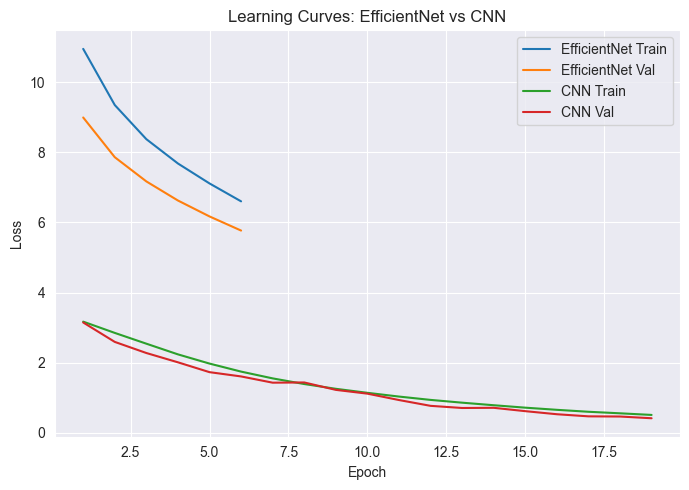

In [25]:
plt.figure(figsize=(7, 5))
epochs_e = range(1, len(history_e.history['loss']) + 1)
epochs_c = range(1, len(history_b.history['loss']) + 1)

plt.plot(epochs_e, history_e.history['loss'], label='EfficientNet Train')
plt.plot(epochs_e, history_e.history['val_loss'], label='EfficientNet Val')
plt.plot(epochs_c, history_b.history['loss'], label='CNN Train')
plt.plot(epochs_c, history_b.history['val_loss'], label='CNN Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves: EfficientNet vs CNN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Figures_Tables/RQ1/RQ1_Fig1.pdf', format='PDF')
plt.show()

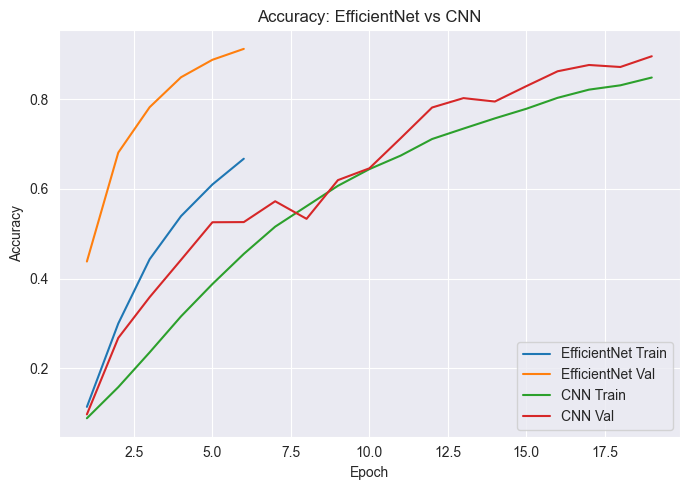

In [26]:
plt.figure(figsize=(7, 5))
plt.plot(epochs_e, history_e.history['accuracy'], label='EfficientNet Train')
plt.plot(epochs_e, history_e.history['val_accuracy'], label='EfficientNet Val')
plt.plot(epochs_c, history_b.history['accuracy'], label='CNN Train')
plt.plot(epochs_c, history_b.history['val_accuracy'], label='CNN Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy: EfficientNet vs CNN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Figures_Tables/RQ1/RQ1_Fig2.pdf', format='PDF')
plt.show()


In [49]:
summary = pd.DataFrame({
    "Model": ["EfficientNet", "CNN"],
    "Accuracy": [acc_e, acc_b],
    "Macro Precision": [prec_e, prec_b],
    "Macro Recall": [rec_e, rec_b],
    "Macro F1": [f1_e, f1_b],
})
print(summary)
summary.to_excel('Figures_Tables/RQ1/RQ1_Tab1.xlsx', index=False)


          Model  Accuracy  Macro Precision  Macro Recall  Macro F1
0  EfficientNet  0.913645         0.918341      0.912377  0.913237
1           CNN  0.888176         0.895569      0.886211  0.886962


In [ ]:
plot_model(
    model_b,
    to_file='Figures_Tables/RQ1/RQ1_Fig3.pdf',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=300,
    show_layer_activations=True
)

In [ ]:
plot_model(
    model_c,
    to_file='Figures_Tables/RQ1/RQ1_Fig4.pdf',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=300,
    show_layer_activations=True
)

RQ2

Raw Pixels vs Pose‑Invariant Landmarks

In [50]:
df_feat = pd.DataFrame({
    "Feature Set": ["Pixels (CNN)", "Landmarks (MLP)"],
    "Val Accuracy": [acc_b, acc_c],
    "Macro Precision": [prec_b, prec_c],
    "Macro Recall": [rec_b, rec_c],
    "Macro F1": [f1_b, f1_c],
})
print(df_feat)
df_feat.to_excel('Figures_Tables/RQ2/RQ2_Tab1.xlsx', index=False)

       Feature Set  Val Accuracy  Macro Precision  Macro Recall  Macro F1
0     Pixels (CNN)      0.888176         0.895569      0.886211  0.886962
1  Landmarks (MLP)      0.929237         0.927825      0.925473  0.925398


In [30]:
perturb = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=8,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

pert_gen = perturb.flow_from_directory(predict_path, target_size=IMAGE_SIZE, batch_size=1, class_mode="sparse",
                                       shuffle=False)

proba_cnn_pert = model_b.predict(pert_gen, verbose=0)
y_pred_cnn_pert = np.argmax(proba_cnn_pert, axis=1)
acc_cnn_pert, _, _, _ = get_metrics(y_geo_test, y_pred_cnn_pert)

Found 14174 images belonging to 28 classes.


/Users/ashwinwalunj/asl-recognisation/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [31]:
X_geo_pert_test = []
y_geo_pert_test = []

for step in range(len(pert_gen)):
    rgb_batch, y_batch = next(pert_gen)
    for i in range(rgb_batch.shape[0]):
        img = rgb_batch[i]
        label = int(y_batch[i])

        feat = extract_hand_features_xyz_wrist_norm(img)
        if feat is not None:
            X_geo_pert_test.append(feat)
            y_geo_pert_test.append(label)

X_geo_pert_test = np.array(X_geo_pert_test, dtype="float32")
y_geo_pert_test = np.array(y_geo_pert_test, dtype="int32")

In [32]:
proba_c_pert = model_c.predict(X_geo_pert_test, verbose=0)
y_pred_c_pert = np.argmax(proba_c_pert, axis=1)
acc_c_pert, _, _, _ = get_metrics(y_geo_pert_test, y_pred_c_pert)

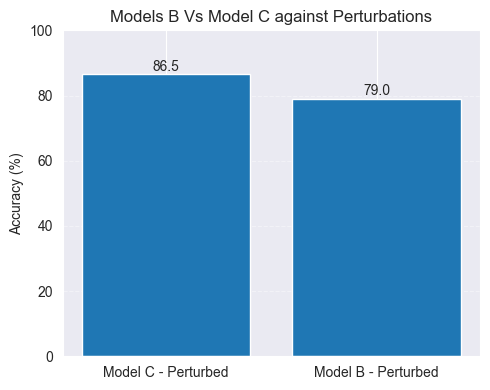

In [33]:
labels = ["Model C - Perturbed", "Model B - Perturbed"]
accs = [acc_c_pert * 100, acc_cnn_pert * 100]

plt.figure(figsize=(5, 4))
bars = plt.bar(labels, accs)
for b, a in zip(bars, accs):
    plt.text(b.get_x() + b.get_width() / 2, b.get_height() + 1, f"{a:.1f}", ha="center")

plt.ylabel("Accuracy (%)")
plt.title("Models B Vs Model C against Perturbations")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('Figures_Tables/RQ2/RQ2_Fig1.pdf', format='PDF')
plt.show()

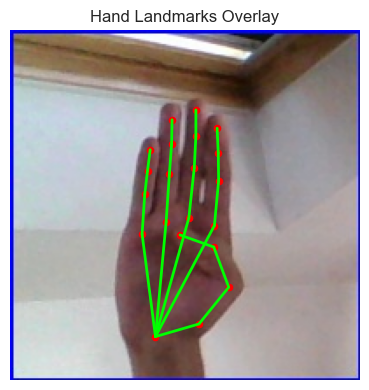

In [34]:
img_bgr = cv2.imread(predict_path + '/B/B1008.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_rgb)
result = landmarker.detect(mp_image)

if not result.hand_landmarks:
    print("No hand detected")
else:
    lm_list = result.hand_landmarks[0]

    h, w, _ = img_rgb.shape
    xs = [lm.x * w for lm in lm_list]
    ys = [lm.y * h for lm in lm_list]

    # 3. Plot image + landmarks
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.scatter(xs, ys, c='red', s=20)

    connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # index
        (0, 9), (9, 10), (10, 11), (11, 12),  # middle
        (0, 13), (13, 14), (14, 15), (15, 16),  # ring
        (0, 17), (17, 18), (18, 19), (19, 20)  # little
    ]
    for i, j in connections:
        plt.plot([xs[i], xs[j]], [ys[i], ys[j]], 'lime', linewidth=2)

    plt.axis('off')
    plt.title("Hand Landmarks Overlay")
    plt.tight_layout()
    plt.savefig('Figures_Tables/RQ2/RQ2_Fig2.pdf', format='PDF')
    plt.show()

In [ ]:
plot_model(
    model_c,
    to_file='Figures_Tables/RQ2/RQ2_Fig3.pdf',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=300,
    show_layer_activations=True
)

RQ3

Resolving Visually Similar Letters

In [36]:
ambiguous_letters = ["A", "E", "M", "N", "S"]
amb_indices = [class_labels.index(c) for c in ambiguous_letters]


In [37]:
def plot_conf_mat_subset(y_true, y_pred, labels, focus_indices, title, figure_name):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    cm_focus = cm[np.ix_(focus_indices, focus_indices)]
    focus_labels = [labels[i] for i in focus_indices]

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm_focus, cmap="Blues")
    ax.set_xticks(range(len(focus_labels)))
    ax.set_xticklabels(focus_labels)
    ax.set_yticks(range(len(focus_labels)))
    ax.set_yticklabels(focus_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

    for i in range(cm_focus.shape[0]):
        for j in range(cm_focus.shape[1]):
            ax.text(j, i, cm_focus[i, j], ha="center", va="center", color="black")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.savefig(figure_name, format='PDF')
    plt.show()


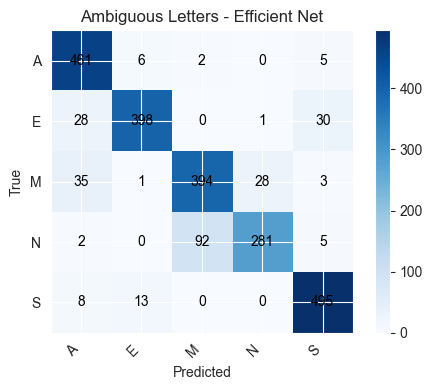

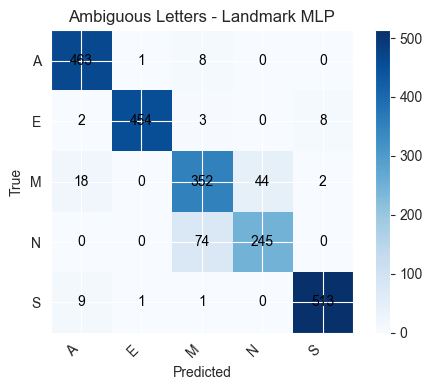

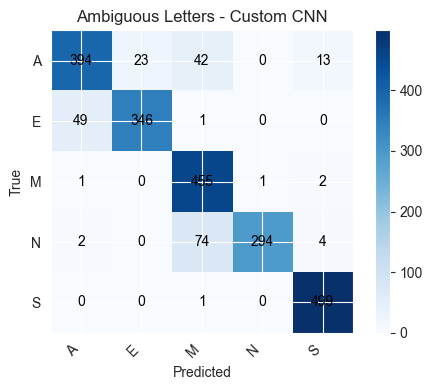

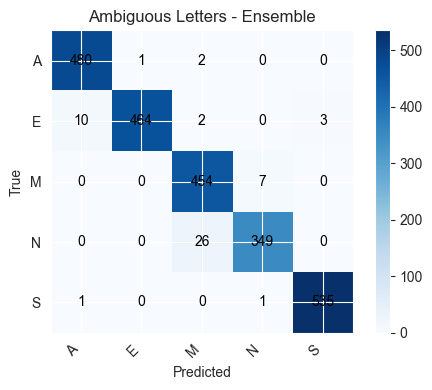

In [38]:
plot_conf_mat_subset(y_geo_test, y_pred_e, class_labels, amb_indices,
                     "Ambiguous Letters - Efficient Net", "Figures_Tables/RQ3/RQ3_Fig1.pdf")

plot_conf_mat_subset(y_geo_test, y_pred_c, class_labels, amb_indices,
                     "Ambiguous Letters - Landmark MLP", "Figures_Tables/RQ3/RQ3_Fig2.pdf")

plot_conf_mat_subset(y_geo_test, y_pred_b, class_labels, amb_indices,
                     "Ambiguous Letters - Custom CNN", "Figures_Tables/RQ3/RQ3_Fig3.pdf")

plot_conf_mat_subset(meta_y_test, meta_X_test_pred, class_labels, amb_indices,
                     "Ambiguous Letters - Ensemble", "Figures_Tables/RQ3/RQ3_Fig4.pdf")

In [52]:
report_cnn = classification_report(
    y_geo_test, y_pred_b, output_dict=True, target_names=class_labels, zero_division=0
)
report_geo = classification_report(
    y_geo_test, y_pred_c, output_dict=True, target_names=class_labels, zero_division=0
)
report_eff = classification_report(
    y_geo_test, y_pred_e, output_dict=True, target_names=class_labels, zero_division=0
)
report_meta = classification_report(
    meta_y_test, meta_X_test_pred, output_dict=True, target_names=class_labels, zero_division=0
)

rows = []
for cls in ambiguous_letters:
    rows.append({
        "Class": cls,
        "Err_CNN": 1 - report_cnn[cls]["recall"],
        "Err_Landmarks": 1 - report_geo[cls]["recall"],
        "Err_Efficient": 1 - report_eff[cls]["recall"],
        "Err_Ensemble": 1 - report_meta[cls]["recall"]
    })

df_err = pd.DataFrame(rows)
print(df_err)
df_err.to_excel('Figures_Tables/RQ3/RQ3_Tab1.xlsx', index=False)


  Class   Err_CNN  Err_Landmarks  Err_Efficient  Err_Ensemble
0     A  0.195918       0.055102       0.059184      0.020408
1     E  0.285124       0.061983       0.177686      0.041322
2     M  0.021505       0.243011       0.152688      0.023656
3     N  0.228346       0.356955       0.262467      0.083990
4     S  0.084404       0.058716       0.091743      0.018349


RQ4

Can the stacking meta‑learner learn to trust different base models for different letters, and how does this selective reliance explain its performance gains?


In [53]:
coefs = np.abs(meta_clf.coef_)
C = proba_b_test.shape[1]

coefs_a = coefs[:, :C]
coefs_b = coefs[:, C:2 * C]
coefs_c = coefs[:, 2 * C:3 * C]

trust_A = coefs_a.mean(axis=1)
trust_B = coefs_b.mean(axis=1)
trust_C = coefs_c.mean(axis=1)

trust_sum = (trust_A + trust_B + trust_C) + 1e-8
trust_A_norm = trust_A / trust_sum
trust_B_norm = trust_B / trust_sum
trust_C_norm = trust_C / trust_sum

df_trust = pd.DataFrame({
    "Model E": trust_A_norm,
    "Model B": trust_B_norm,
    "Model C": trust_C_norm,
}, index=class_labels)

df_trust.to_excel('Figures_Tables/RQ4/RQ4_Tab1.xlsx', index=False)
print(df_trust)


        Model E   Model B   Model C
A      0.001915  0.512847  0.485238
B      0.002314  0.578132  0.419554
C      0.002939  0.566430  0.430631
D      0.003635  0.503117  0.493248
E      0.001879  0.487601  0.510520
F      0.001165  0.561070  0.437765
G      0.001335  0.476478  0.522187
H      0.000246  0.579414  0.420341
I      0.000794  0.542102  0.457105
J      0.003217  0.568165  0.428617
K      0.000688  0.544728  0.454584
L      0.005869  0.572257  0.421874
M      0.002874  0.654846  0.342280
N      0.005970  0.551735  0.442295
O      0.000816  0.606818  0.392365
P      0.001073  0.606772  0.392155
Q      0.000199  0.612432  0.387368
R      0.002691  0.572670  0.424639
S      0.000207  0.565916  0.433877
T      0.000314  0.486466  0.513220
U      0.002996  0.469043  0.527961
V      0.000797  0.486488  0.512714
W      0.002407  0.532092  0.465501
X      0.000372  0.558821  0.440806
Y      0.000594  0.508539  0.490867
Z      0.001014  0.559802  0.439184
del    0.001402  0.469469  0

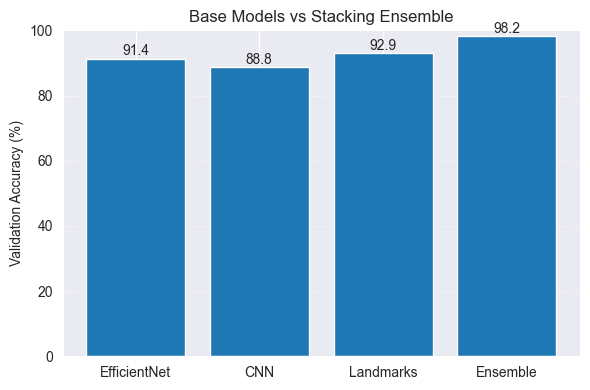

In [41]:
models = ["EfficientNet", "CNN", "Landmarks", "Ensemble"]
accs = [acc_e, acc_b, acc_c, acc_ens]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, [a * 100 for a in accs])
for b, a in zip(bars, accs):
    plt.text(b.get_x() + b.get_width() / 2, a * 100 + 1, f"{a * 100:.1f}", ha="center")

plt.ylabel("Validation Accuracy (%)")
plt.title("Base Models vs Stacking Ensemble")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('Figures_Tables/RQ4/RQ4_Fig1.pdf', format='PDF')
plt.show()


In [61]:
def per_class_accuracy(y_true, y_pred, n_classes):
    accs = []
    for cls in range(n_classes):
        mask = (y_true == cls)
        if mask.sum() == 0:
            accs.append(np.nan)
        else:
            accs.append((y_pred[mask] == y_true[mask]).mean())
    return np.array(accs)

acc_cnn_cls = per_class_accuracy(y_geo_test,y_pred_b,n_classes)
acc_eff_cls = per_class_accuracy(y_geo_test,y_pred_e,n_classes)
acc_geo_cls = per_class_accuracy(y_geo_test,y_pred_c,n_classes)
acc_ens_cls = per_class_accuracy(meta_y_test, meta_X_test_pred, n_classes)

df_cls = pd.DataFrame({
    "Class": class_labels,
    "Acc_CNN": acc_cnn_cls,
    "Acc_EfficientNet": acc_eff_cls,
    "Acc_Landmarks": acc_geo_cls,
    "Acc_Ensemble": acc_ens_cls
})
print(df_cls)
df_cls.to_excel('Figures_Tables/RQ4/RQ4_Tab2.xlsx', index=False)


    Class   Acc_CNN  Acc_EfficientNet  Acc_Landmarks  Acc_Ensemble
0       A  0.804082          0.940816       0.944898      0.979592
1       B  0.766595          0.995717       0.980728      0.989293
2       C  0.980687          0.989270       0.967811      1.000000
3       D  0.888278          0.979853       0.968864      0.981685
4       E  0.714876          0.822314       0.938017      0.958678
5       F  0.988176          0.986486       0.959459      1.000000
6       G  0.813996          0.948435       0.966851      1.000000
7       H  0.919386          0.986564       0.950096      0.990403
8       I  0.978641          0.867961       0.916505      0.978641
9       J  0.972325          0.856089       0.942804      1.000000
10      K  0.983784          0.850450       0.969369      0.996396
11      L  1.000000          0.970093       0.960748      1.000000
12      M  0.978495          0.847312       0.756989      0.976344
13      N  0.771654          0.737533       0.643045      0.91

RQ5

Do different model types exhibit systematic biases in performance between “easy” signs (high visual distinctiveness) and “hard” signs (visually similar letters), and how effectively does the ensemble reduce this gap?

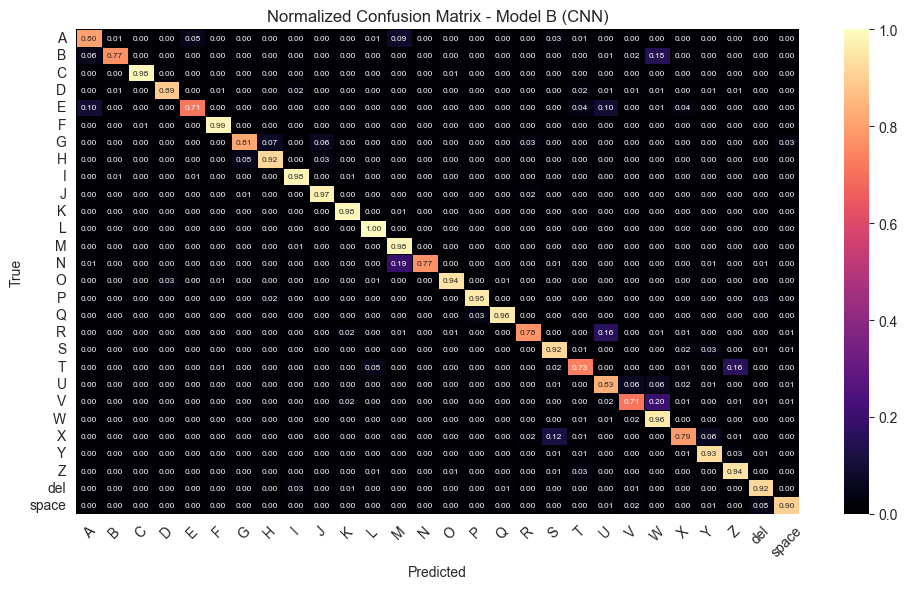

In [55]:
cm = confusion_matrix(y_geo_test, y_pred_b, labels=range(len(class_labels)))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="magma",
    cbar=True,
    linewidths=0.5,
    linecolor="black",
    annot_kws={"size": 6}
)

plt.xticks(
    np.arange(len(class_labels)) + 0.5,
    class_labels,
    rotation=45
)
plt.yticks(
    np.arange(len(class_labels)) + 0.5,
    class_labels,
    rotation=0
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix - Model B (CNN)")
plt.tight_layout()
plt.savefig('Figures_Tables/RQ5/RQ5_Fig1.pdf', format='PDF')
plt.show()


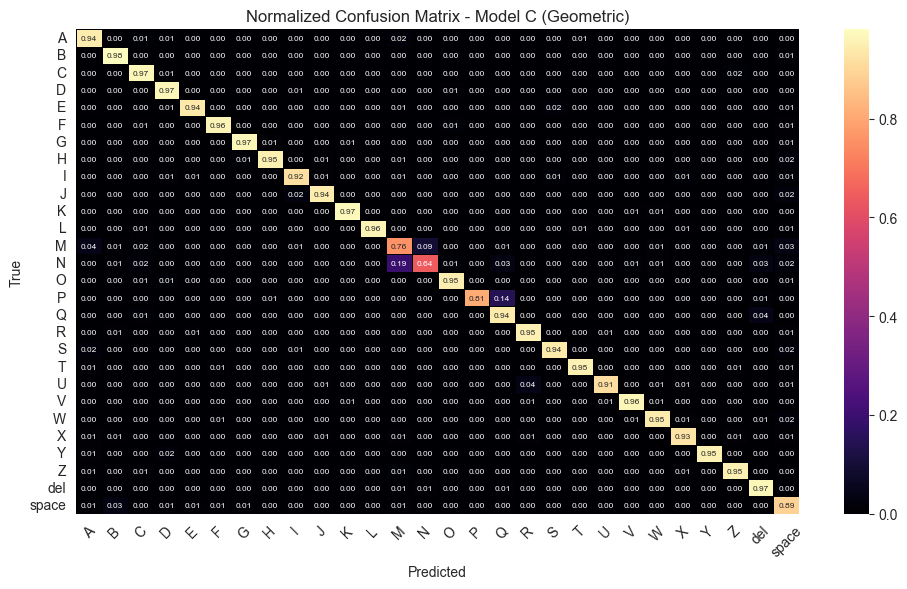

In [56]:
cm = confusion_matrix(y_geo_test, y_pred_c, labels=range(len(class_labels)))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="magma",
    cbar=True,
    linewidths=0.5,
    linecolor="black",
    annot_kws={"size": 6}
)

plt.xticks(
    np.arange(len(class_labels)) + 0.5,
    class_labels,
    rotation=45
)
plt.yticks(
    np.arange(len(class_labels)) + 0.5,
    class_labels,
    rotation=0
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix - Model C (Geometric)")
plt.tight_layout()
plt.savefig('Figures_Tables/RQ5/RQ5_Fig2.pdf', format='PDF')
plt.show()


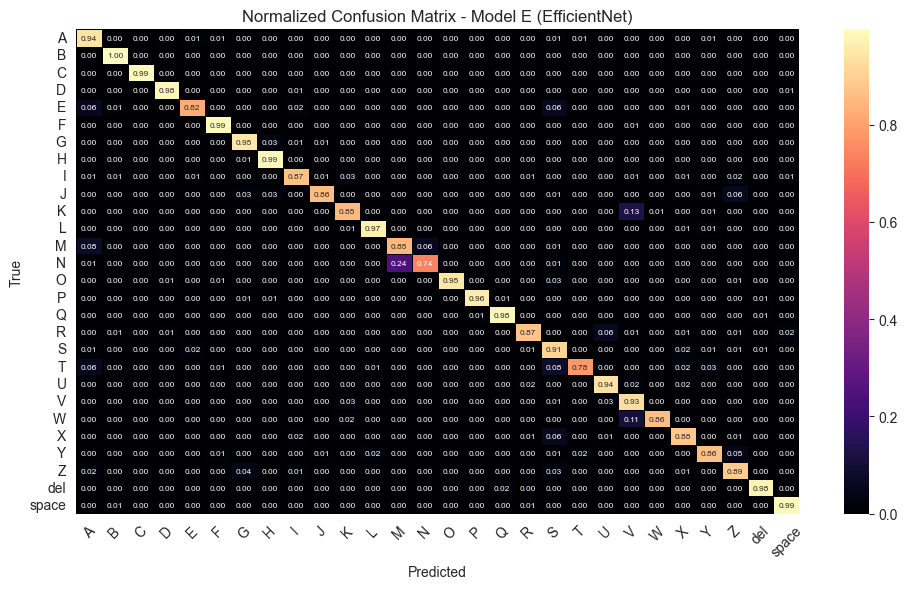

In [57]:
cm = confusion_matrix(y_geo_test, y_pred_e, labels=range(len(class_labels)))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="magma",
    cbar=True,
    linewidths=0.5,
    linecolor="black",
    annot_kws={"size": 6}
)

plt.xticks(
    np.arange(len(class_labels)) + 0.5,
    class_labels,
    rotation=45
)
plt.yticks(
    np.arange(len(class_labels)) + 0.5,
    class_labels,
    rotation=0
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix - Model E (EfficientNet)")
plt.tight_layout()
plt.savefig('Figures_Tables/RQ5/RQ5_Fig3.pdf', format='PDF')
plt.show()


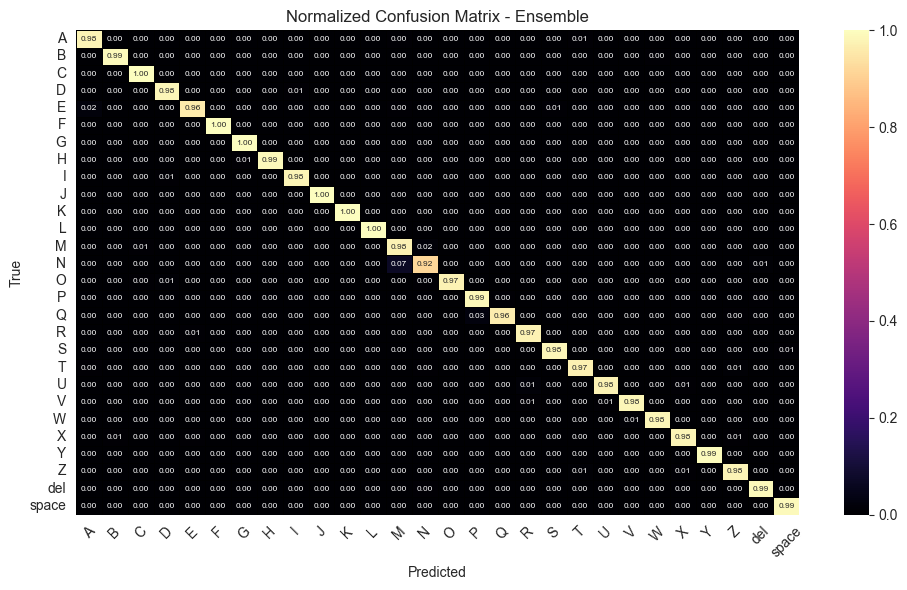

In [58]:
cm = confusion_matrix(meta_y_test, meta_X_test_pred, labels=range(len(class_labels)))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="magma",
    cbar=True,
    linewidths=0.5,
    linecolor="black",
    annot_kws={"size": 6}
)

plt.xticks(
    np.arange(len(class_labels)) + 0.5,
    class_labels,
    rotation=45
)
plt.yticks(
    np.arange(len(class_labels)) + 0.5,
    class_labels,
    rotation=0
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix - Ensemble")
plt.tight_layout()
plt.savefig('Figures_Tables/RQ5/RQ5_Fig4.pdf', format='PDF')
plt.show()
